# **Tutorial 6: Scenario-dependence of Future Changes in Extremes**

**Week 2, Day 4, Extremes & Vulnerability**

**Content creators:** Matthias Aengenheyster, Joeri Reinders

**Content reviewers:** Younkap Nina Duplex, Sloane Garelick, Zahra Khodakaramimaghsoud, Peter Ohue, Laura Paccini, Jenna Pearson, Agustina Pesce, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this tutorial, we will analyze climate model output for various cities worldwide to investigate the changes in extreme temperature and precipitation patterns over time under different emission scenarios.

The data we will be using consists of climate model simulations for the historical period and three future climate scenarios:

1. **Historical (hist)**: This scenario covers the time range from 1851 to 2014 and incorporates information about volcanic eruptions, greenhouse gas emissions, and other factors relevant to historical climate conditions.

The Socio-economic pathway (SSP) scenarios represent potential climate futures beyond 2014. It's important to note that these scenarios are predictions ("this is what we think will happen") but are not certainties ("this is plausible given the assumptions"). Each scenario is based on different assumptions, primarily concerning the speed and effectiveness of global efforts to address global warming and reduce greenhouse gas emissions and other pollutants. Here are the scenarios we will be using today, along with desciptions [(see Section 1.6 of the recent IPCC AR6 WG1 report for more detail)](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-1/#1.6)

2. **SSP1-2.6** *(ambitious climate scenario)*: This scenario stays below 2.0°C warming relative to 1850–1900 (median) with implied net zero CO2 emissions in the second half of the century.
3. **SSP2-4.5** *(middle-ground climate scenario)*: This scenario is in line with the upper end of aggregate NDC (nationally-defined contribution) emissions levels by 2030. CO2 emissions remain around current levels until the middle of the century. The SSP2-4.5 scenario deviates mildly from a ‘no-additional-climate-policy’ reference scenario, resulting in a best-estimate warming around 2.7°C by the end of the 21st century relative to 1850–1900 (Chapter 4).
4. **SSP5-8.5** *(pessimistic climate scenario)*: The highest emissions scenario with no additional climate policy and where CO2 emissions roughly double from current levels by 2050. Emissions levels as high as SSP5-8.5 are not obtained by integrated assessment models (IAMs) under any of the SSPs other than the fossil-fuelled SSP5 socio-economic development pathway. It exhibits the highest level of warming among all scenarios and is often used as a "worst-case scenario" (though it may not be the most likely outcome). It is worth noting that many experts today consider this scenario to be unlikely due to significant improvements in mitigation policies over the past decade or so.

By the end of this tutorial, you will be able to:

- Utilize climate model output from scenario runs to assess changes during the historical period.
- Compare potential future climate scenarios, focusing on their impact on extreme events.

# **Setup**

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [9]:
# imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
from scipy import stats
from datetime import datetime
import os
import pooch

In [10]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [ ]:
# @title Helper functions

def estimate_return_level_period(period,loc,scale,shape):
    '''
    Compute GEV-based return level for a given return period, and GEV parameters
    '''
    return stats.genextreme.ppf(1-1/period,shape,loc=loc,scale=scale)

def empirical_return_level(data):
    '''
    Compute empirical return level using the algorithm introduced in Tutorial 2
    '''
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df['sorted'] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df['ranks_sp'] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df['exceedance'] = df['ranks_sp']/(n+1)
    # find return period
    df['period'] = 1 / df['exceedance']

    df = df[::-1]

    out = xr.DataArray(
        dims=['period'],
        coords={'period':df['period']},
        data=df['sorted'],name='level')
    return out

def fit_return_levels(data,years,N_boot=None,alpha=0.05):
    '''
    Fit GEV to data, compute return levels and confidence intervals
    '''
    empirical = empirical_return_level(data).rename({'period':'period_emp'}).rename('empirical')
    shape, loc, scale = gev.fit(data,0)
    print('Location: %.1e, scale: %.1e, shape: %.1e' % (loc, scale, shape))
    central = estimate_return_level_period(years,loc,scale,shape)

    out = xr.Dataset(
        # dims = ['period'],
        coords = {
            'period': years,
            'period_emp': empirical['period_emp']
            },
        data_vars={
            'empirical':(['period_emp'],empirical.data),
            'GEV':(['period'],central)
            }
    )

    if N_boot:
        levels = []
        shapes, locs, scales = [],[],[]
        for i in range(N_boot):
            datai = np.random.choice(data,size=data.size,replace=True)
            # print(datai.mean())
            shapei,loci,scalei = gev.fit(datai,0)
            shapes.append(shapei)
            locs.append(loci)
            scales.append(scalei)
            leveli = estimate_return_level_period(years,loci,scalei,shapei)
            levels.append(
                leveli
            )

        levels = np.array(levels)
        quant = alpha / 2, 1-alpha/2
        quantiles = np.quantile(levels,quant,axis=0)

        print('Ranges with alpha=%.3f :' % alpha)
        print('Location: [%.2f , %.2f]'  % tuple(np.quantile(locs,quant).tolist()))
        print('Scale: [%.2f , %.2f]'  % tuple(np.quantile(scales,quant).tolist()))
        print('Shape: [%.2f , %.2f]'  % tuple(np.quantile(shapes,quant).tolist()))

        quantiles = xr.DataArray(
            dims=['period','quantiles'],
            coords={'period':out.period,'quantiles':np.array(quant)},
            data=quantiles.T
        )
        out['range'] = quantiles
    return out

def plot_return_levels(obj,c='C0',label='',ax=None):
    '''
    Plot fitted data:
        - empirical return level
        - GEV-fitted return level
        - alpha-confidence ranges with bootstrapping (if N_boot is given)
    '''
    if not ax:
        ax = plt.gca()
    obj['GEV'].plot.line('%s-' % c,lw=3,_labels=False,label=label,ax=ax)
    obj['empirical'].plot.line('%so' % c,mec='k',markersize=5,_labels=False,ax=ax)
    if 'range' in obj:
        # obj['range'].plot.line('k--',hue='quantiles',label=obj['quantiles'].values)
        ax.fill_between(obj['period'],*obj['range'].T,alpha=0.3,lw=0,color=c) 
    ax.semilogx()
    ax.legend()

In [4]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# **Section 1: Load CMIP6 Data**


As in IPCC Physical Basis Day, you will be loading  (Coupled Model Intercomparison Project 6) CMIP6 data from [Pangeo](https://pangeo.io/). In this way you can access large amounts of climate model output that has been stored in the cloud. Here, we have already accessed the data of interest and collected it into a .nc file for you. However, the information on how to access this data directly is provided in the Resources section at the end of this notebook.

Here you will load precipitatation and maximum daily near-surface air temperature.

In [6]:
# download file: 'cmip6_data_city_daily_scenarios_tasmax_pr_models.nc'
url_cmip6_data = "https://osf.io/ngafk/download"
data = xr.open_dataset(pooch.retrieve(url_cmip6_data, known_hash=None))

# **Section 2: Inspect Data**

In [7]:
data

<xarray.Dataset>
Dimensions:         (model: 2, city: 6, bnds: 2, scenario: 3, time: 91676)
Coordinates:
    lat             (model, city) float64 ...
    lat_bnds        (model, city, bnds) float64 ...
    lon             (model, city) float64 ...
    lon_bnds        (model, city, bnds) float64 ...
  * time            (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T...
    time_bnds       (time, bnds) datetime64[ns] ...
    member_id       object ...
    dcpp_init_year  float64 ...
    height          float64 ...
  * city            (city) object 'Hamburg' 'Madrid' ... 'Phoenix' 'Sydney'
  * scenario        (scenario) object 'ssp126' 'ssp245' 'ssp585'
  * model           (model) object 'MPI-ESM1-2-HR' 'MIROC6'
Dimensions without coordinates: bnds
Data variables:
    pr              (model, city, scenario, time) float64 ...
    tasmax          (model, city, scenario, time) float32 ...
Attributes: (12/56)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn

In [16]:
data.pr

<xarray.DataArray 'pr' (model: 2, city: 6, scenario: 3, time: 91676)>
[3300336 values with dtype=float64]
Coordinates:
    lat             (model, city) float64 ...
    lon             (model, city) float64 ...
  * time            (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T...
    member_id       object ...
    dcpp_init_year  float64 ...
    height          float64 ...
  * city            (city) object 'Hamburg' 'Madrid' ... 'Phoenix' 'Sydney'
  * scenario        (scenario) object 'ssp126' 'ssp245' 'ssp585'
  * model           (model) object 'MPI-ESM1-2-HR' 'MIROC6'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        includes both liquid and solid phases
    history:        2019-08-25T06:42:13Z altered by CMOR: replaced missing va...
    long_name:      Precipitation
    original_name:  pr
    standard_name:  precipitation_flux
    units:          mm/day

In [17]:
data.tasmax

<xarray.DataArray 'tasmax' (model: 2, city: 6, scenario: 3, time: 91676)>
[3300336 values with dtype=float32]
Coordinates:
    lat             (model, city) float64 ...
    lon             (model, city) float64 ...
  * time            (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T...
    member_id       object ...
    dcpp_init_year  float64 ...
    height          float64 ...
  * city            (city) object 'Hamburg' 'Madrid' ... 'Phoenix' 'Sydney'
  * scenario        (scenario) object 'ssp126' 'ssp245' 'ssp585'
  * model           (model) object 'MPI-ESM1-2-HR' 'MIROC6'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-08-25T06:42:13Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

You can take a little time to explore the different variables within this dataset.

# **Section 2: Processing**

Let's look at the data for one selected city, for one climate model. In this case here, we choose Madrid and the `MPI-ESM1-2-HR` model.

In [12]:
city = 'Madrid'
data_city = data.sel(city=city,model='MPI-ESM1-2-HR')

In [13]:
data_city

<xarray.Dataset>
Dimensions:         (bnds: 2, scenario: 3, time: 91676)
Coordinates:
    lat             float64 ...
    lat_bnds        (bnds) float64 ...
    lon             float64 ...
    lon_bnds        (bnds) float64 ...
  * time            (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T...
    time_bnds       (time, bnds) datetime64[ns] ...
    member_id       object ...
    dcpp_init_year  float64 ...
    height          float64 ...
    city            <U6 'Madrid'
  * scenario        (scenario) object 'ssp126' 'ssp245' 'ssp585'
    model           <U13 'MPI-ESM1-2-HR'
Dimensions without coordinates: bnds
Data variables:
    pr              (scenario, time) float64 ...
    tasmax          (scenario, time) float32 ...
Attributes: (12/56)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn

The data has daily resolution, for three climate scenarios. Until 2014 the scenarios are identical (the 'historical' scenario). After 2014 they diverge given different climate change trajectories. Let's plot these two variables over time to get a sense of this.

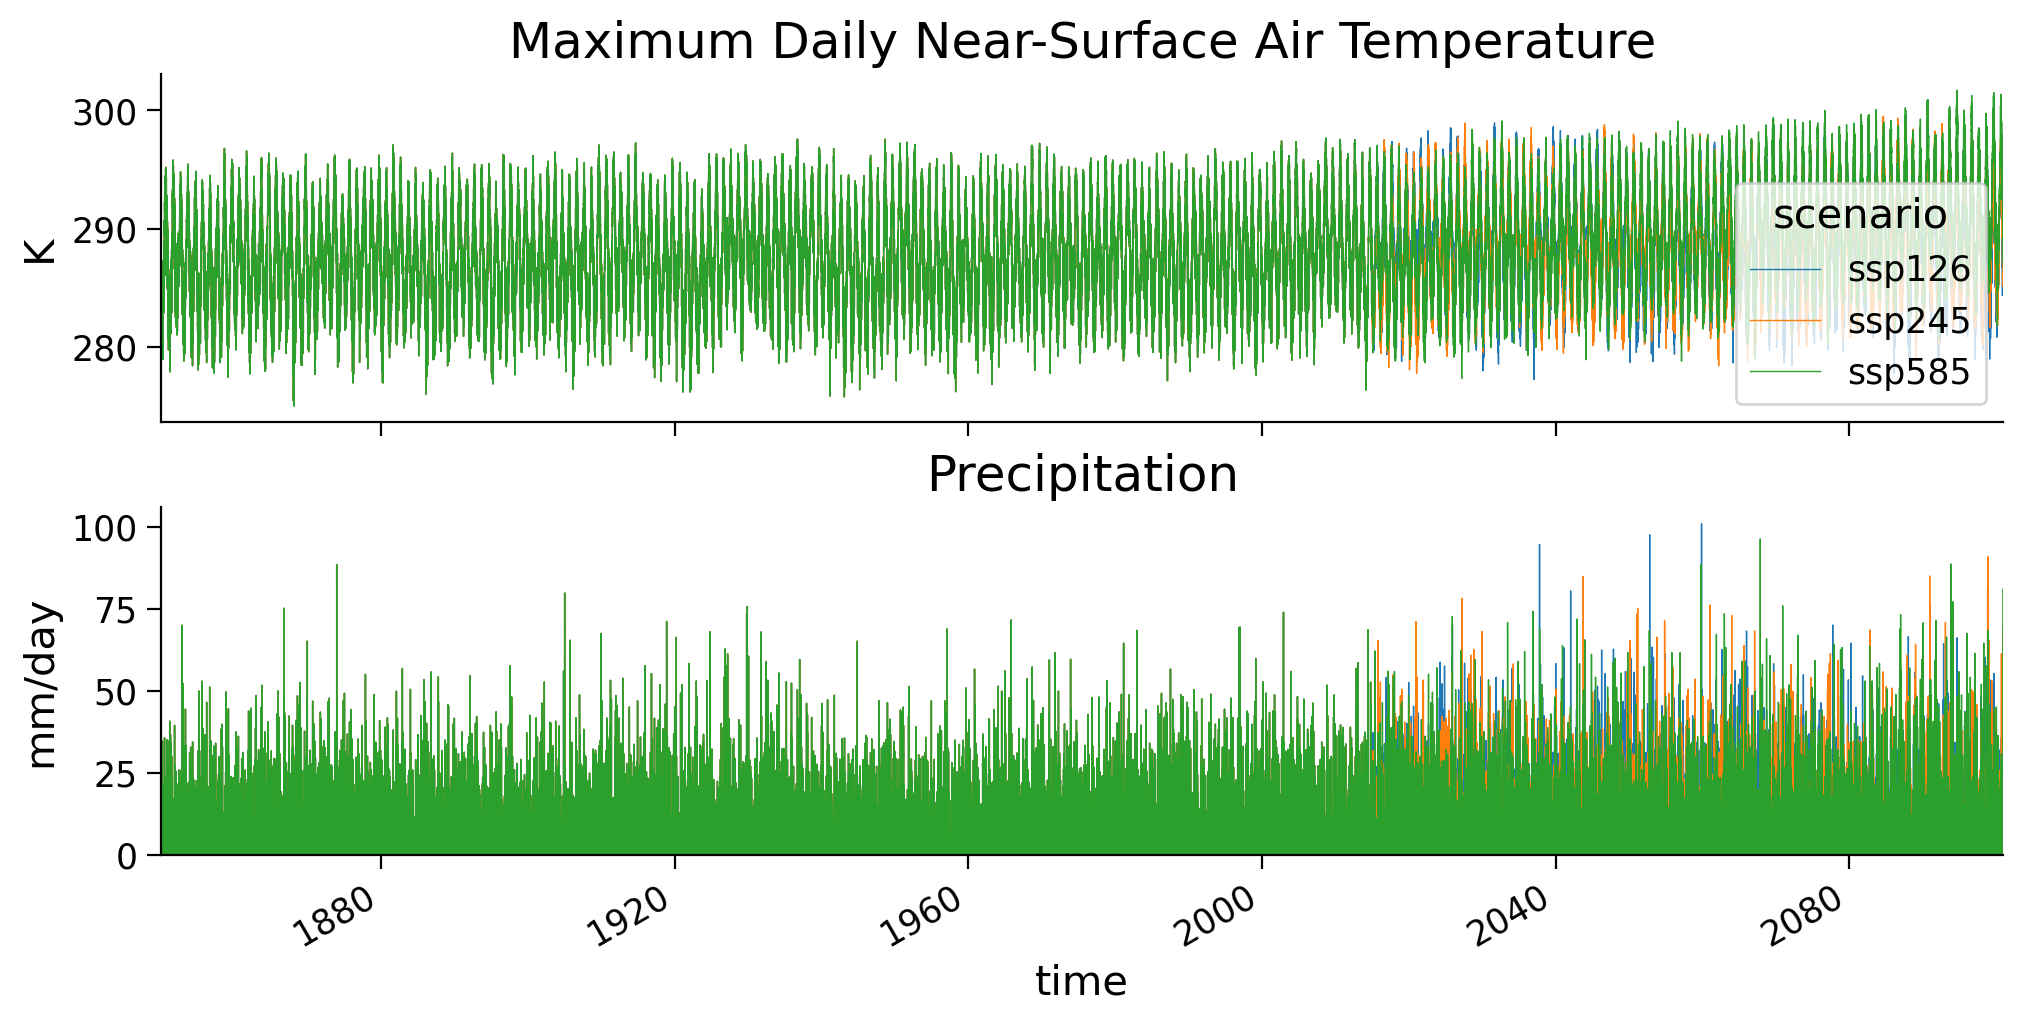

In [21]:
# setup plot
fig, ax = plt.subplots(2,sharex=True,figsize=(10,5),constrained_layout=True)
data_city['tasmax'].plot(hue='scenario',ax=ax[0],lw=0.5)
data_city['pr'].plot(hue='scenario',ax=ax[1],lw=0.5,add_legend=False)

ax[0].set_title('Maximum Daily Near-Surface Air Temperature')
ax[1].set_title('Precipitation')

ax[0].set_xlabel('')

ax[0].set_ylabel('K')
ax[1].set_ylabel('mm/day')

ax[0].set_xlim(
    datetime(1850,1,1),
    datetime(2100,12,31)
)

ax[1].set_ylim(0,None);

In the previous tutorials we have been operating on annual maxima data - looking at the most extreme event observed in each year. We will do the same here: take the day in each year with the highest temperature or the largest amount of rainfall

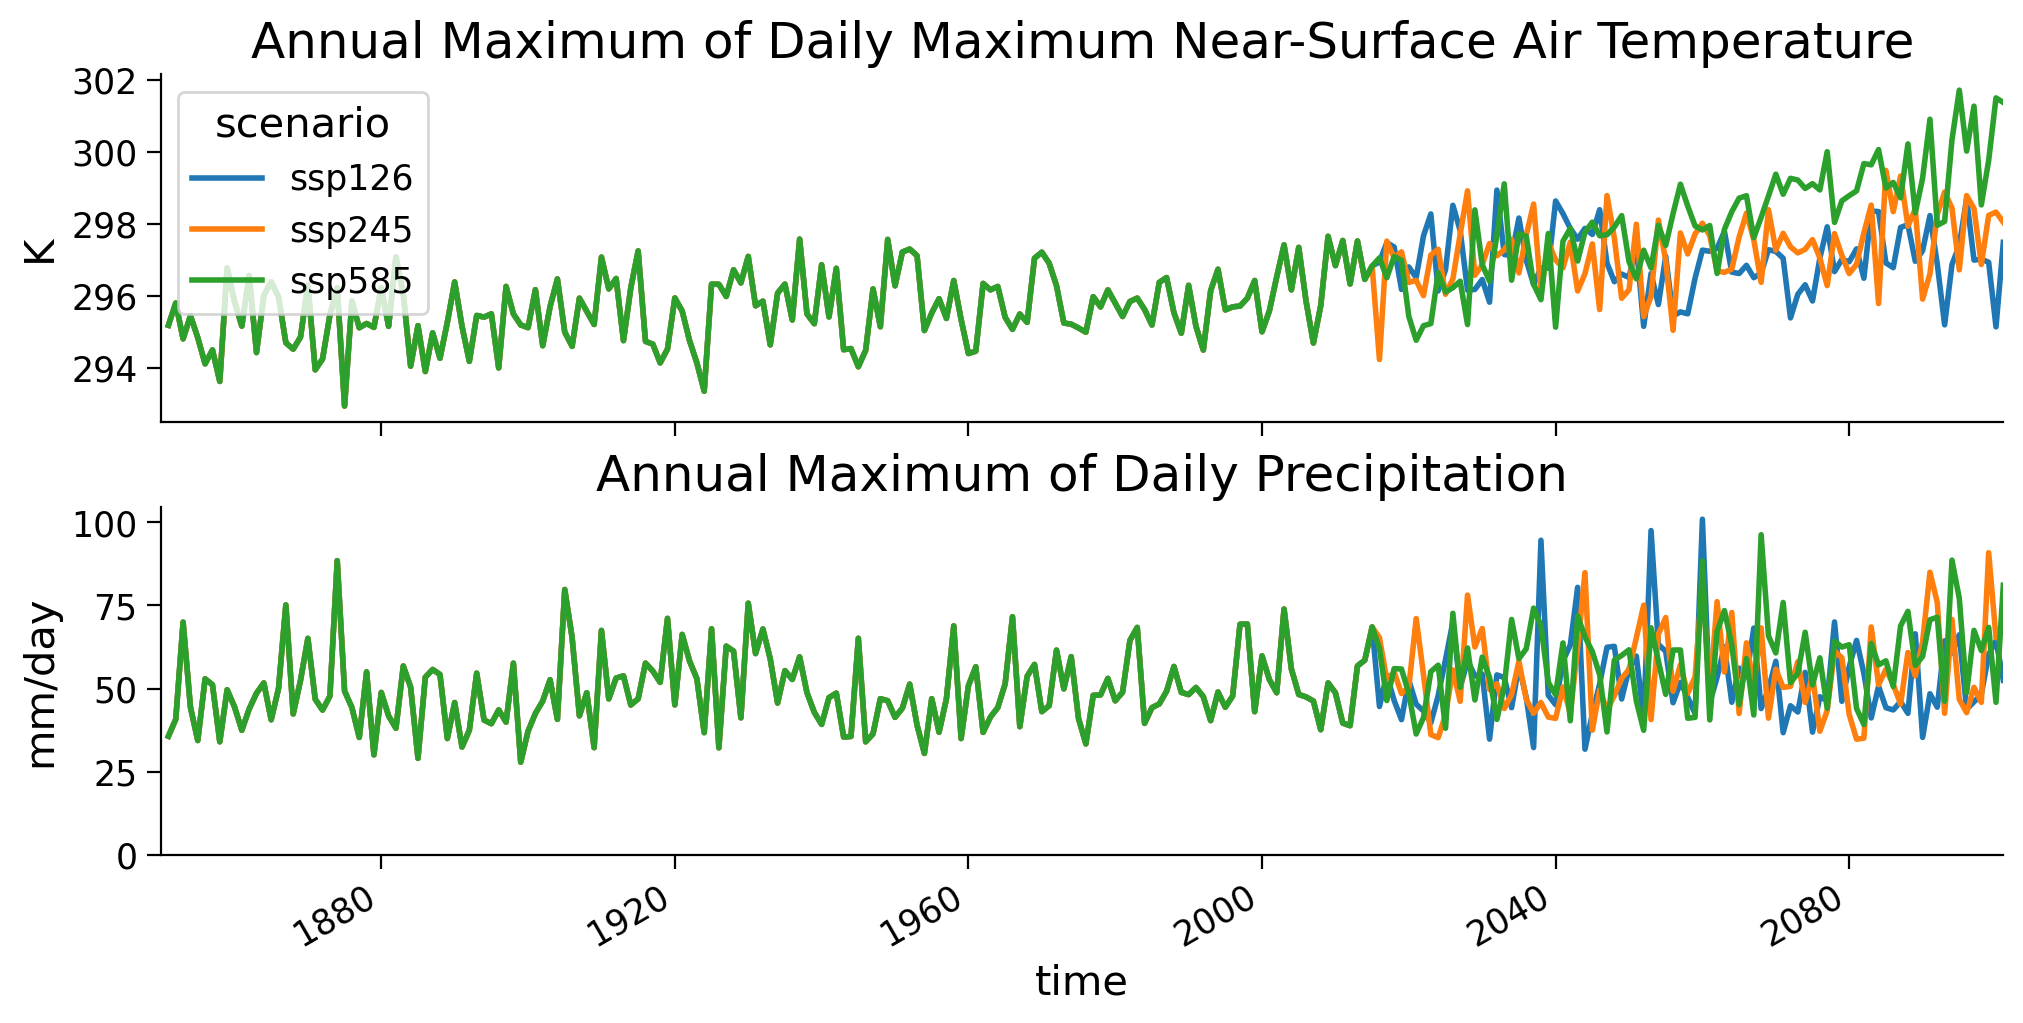

In [25]:
fig, ax = plt.subplots(2,sharex=True,figsize=(10,5),constrained_layout=True)
data_city['tasmax'].resample(time='1Y').max().plot(hue='scenario',ax=ax[0],lw=2)
data_city['pr'].resample(time='1Y').max().plot(hue='scenario',ax=ax[1],lw=2,add_legend=False)

ax[0].set_title('Annual Maximum of Daily Maximum Near-Surface Air Temperature')
ax[1].set_title('Annual Maximum of Daily Precipitation')

ax[0].set_xlabel('')

ax[0].set_ylabel('K')
ax[1].set_ylabel('mm/day')

ax[0].set_xlim(
    datetime(1850,1,1),
    datetime(2100,12,31)
)

ax[1].set_ylim(0,None);

## **Questions 2** 
1. Describe the plot - what do you see for the two variables, over time, between scenarios?

In [24]:
# to_remove explanation
"""
1. Possible answer: For near-surface air tempereature, there tends to be an increase from ssp 126 to ssp 585. For rainfall, the variability rather than the trend seems to be changing the most.
""";

# **Section 3: Differences Between Historical Periods**

As in the previous tutorial we want to compare consecutive 30-year periods in the past: therefore take the historical run (1850-2014), and look at the annual maximum daily precipitation for the last three 30-year periods. We only need to look at one scenario because they all use the historical run until 2014.

In [29]:
# take max daily precip values from Madrid for three climate normal periods
pr_city = data_city['pr']
pr_city_max= pr_city.resample(time='1Y').max()

data_period1 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1925','1954')).to_dataframe()['pr']
data_period2 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1955','1984')).to_dataframe()['pr']
data_period3 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1985','2014')).to_dataframe()['pr']

Plot the histograms of annual maximum daily precipitation for the three climate normals covering the historical period. What do you see? Compare to the analysis in the previous tutorial where we analyzed sea level height. Any similarities or differences? Why do you think that is?

Text(0.5, 0, 'Annual Maximum Daily Precipitation (mm/day)')

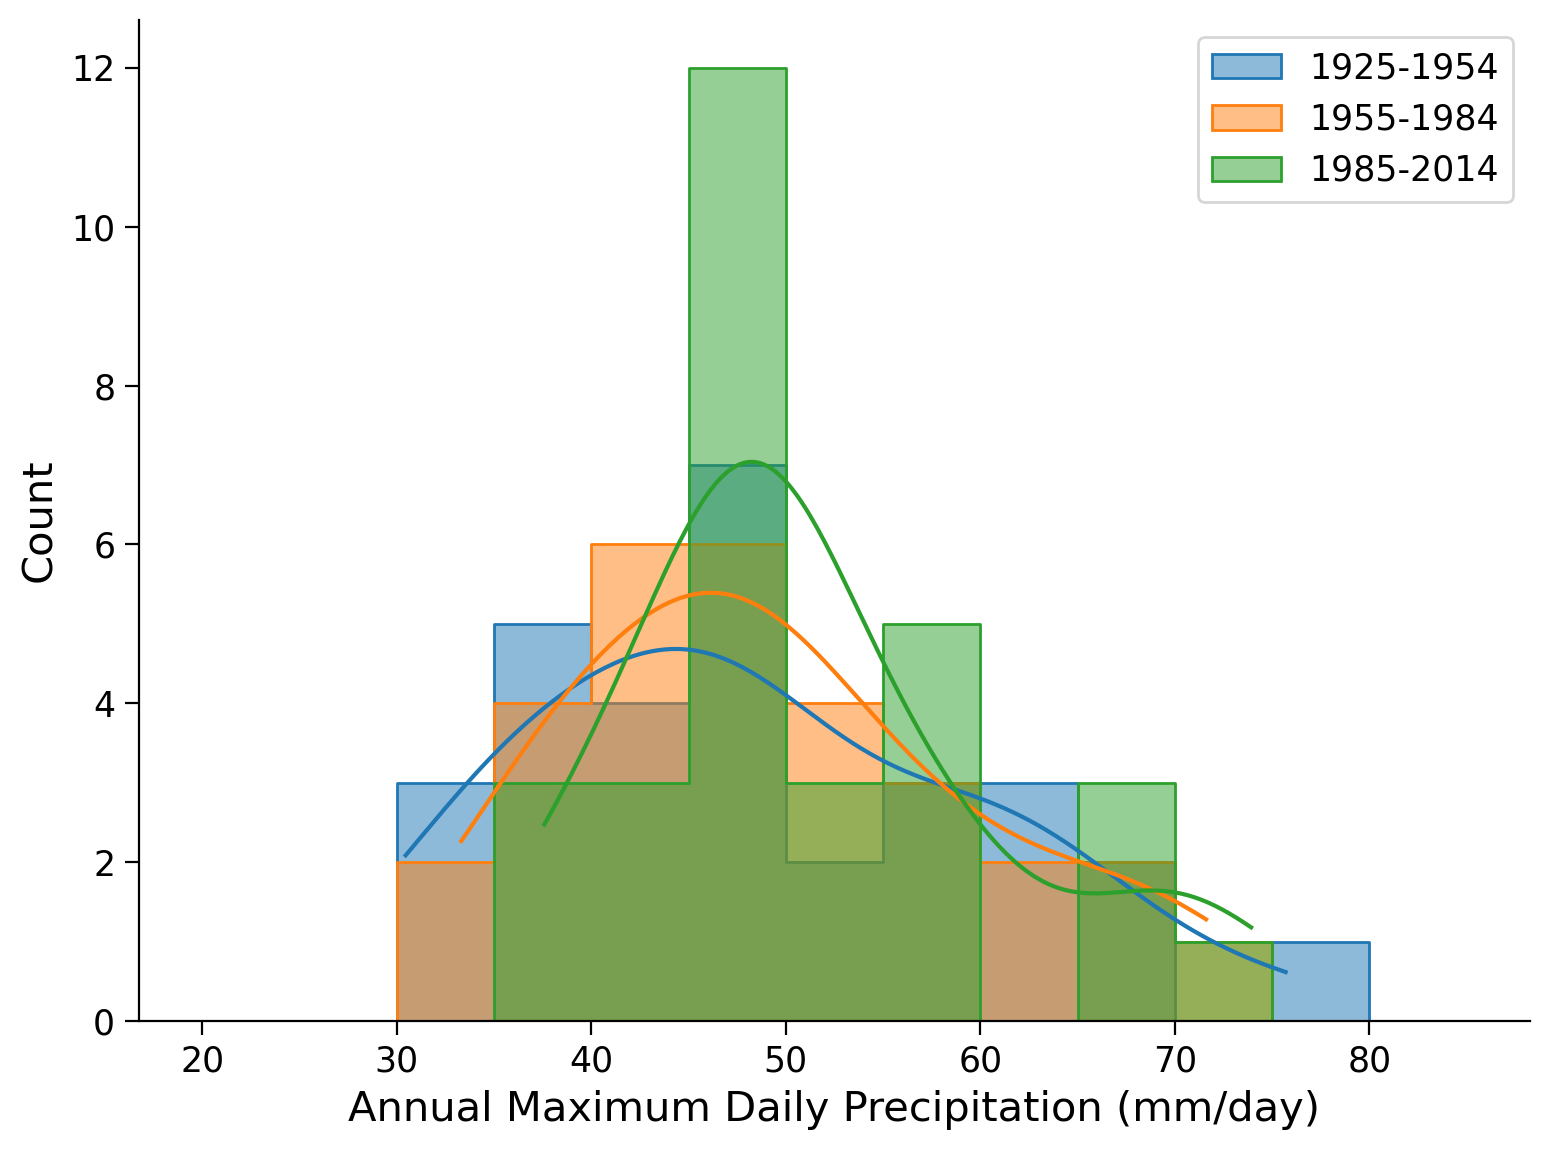

In [28]:
# plot histograms for climate normals during historical period
fig,ax=plt.subplots()
sns.histplot(data_period1,bins=np.arange(20,90,5),color='C0',element='step',alpha=0.5,kde=True,label='1925-1954',ax=ax)
sns.histplot(data_period2,bins=np.arange(20,90,5),color='C1',element='step',alpha=0.5,kde=True,label='1955-1984',ax=ax)
sns.histplot(data_period3,bins=np.arange(20,90,5),color='C2',element='step',alpha=0.5,kde=True,label='1985-2014',ax=ax)
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation (mm/day)')

In [31]:
# calculate moments of the data
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])
periods_stats['1925-1954'] = [data_period1.mean(), data_period1.std(), data_period1.skew()]
periods_stats['1955-1984'] = [data_period2.mean(), data_period2.std(), data_period2.skew()]
periods_stats['1985-2014'] = [data_period3.mean(), data_period3.std(), data_period3.skew()]

periods_stats = periods_stats.T
periods_stats

,Mean,Standard Deviation,Skew
1925-1954,48.430939,11.521903,0.485490
1955-1984,49.461359,10.390394,0.547118
1985-2014,51.412866,9.354812,0.905246


Now, we fit a GEV to the three time periods, and plot the distributions using the gev.pdf function:

In [32]:
# reminder of how to fit function works and the output shape parameters
gev = stats.genextreme
gev.fit(data_period1.values)

(0.09307355209208032, 43.51828403778693, 9.769295887460995)

In [33]:
# fit GEV distribution for three climate normals during historical period
params_period1 = gev.fit(data_period1,0)
shape_period1, loc_period1, scale_period1 = params_period1
params_period2 = gev.fit(data_period2,0)
shape_period2, loc_period2, scale_period2 = params_period2
params_period3 = gev.fit(data_period3,0)
shape_period3, loc_period3, scale_period3 = params_period3

Text(0, 0.5, 'Density')

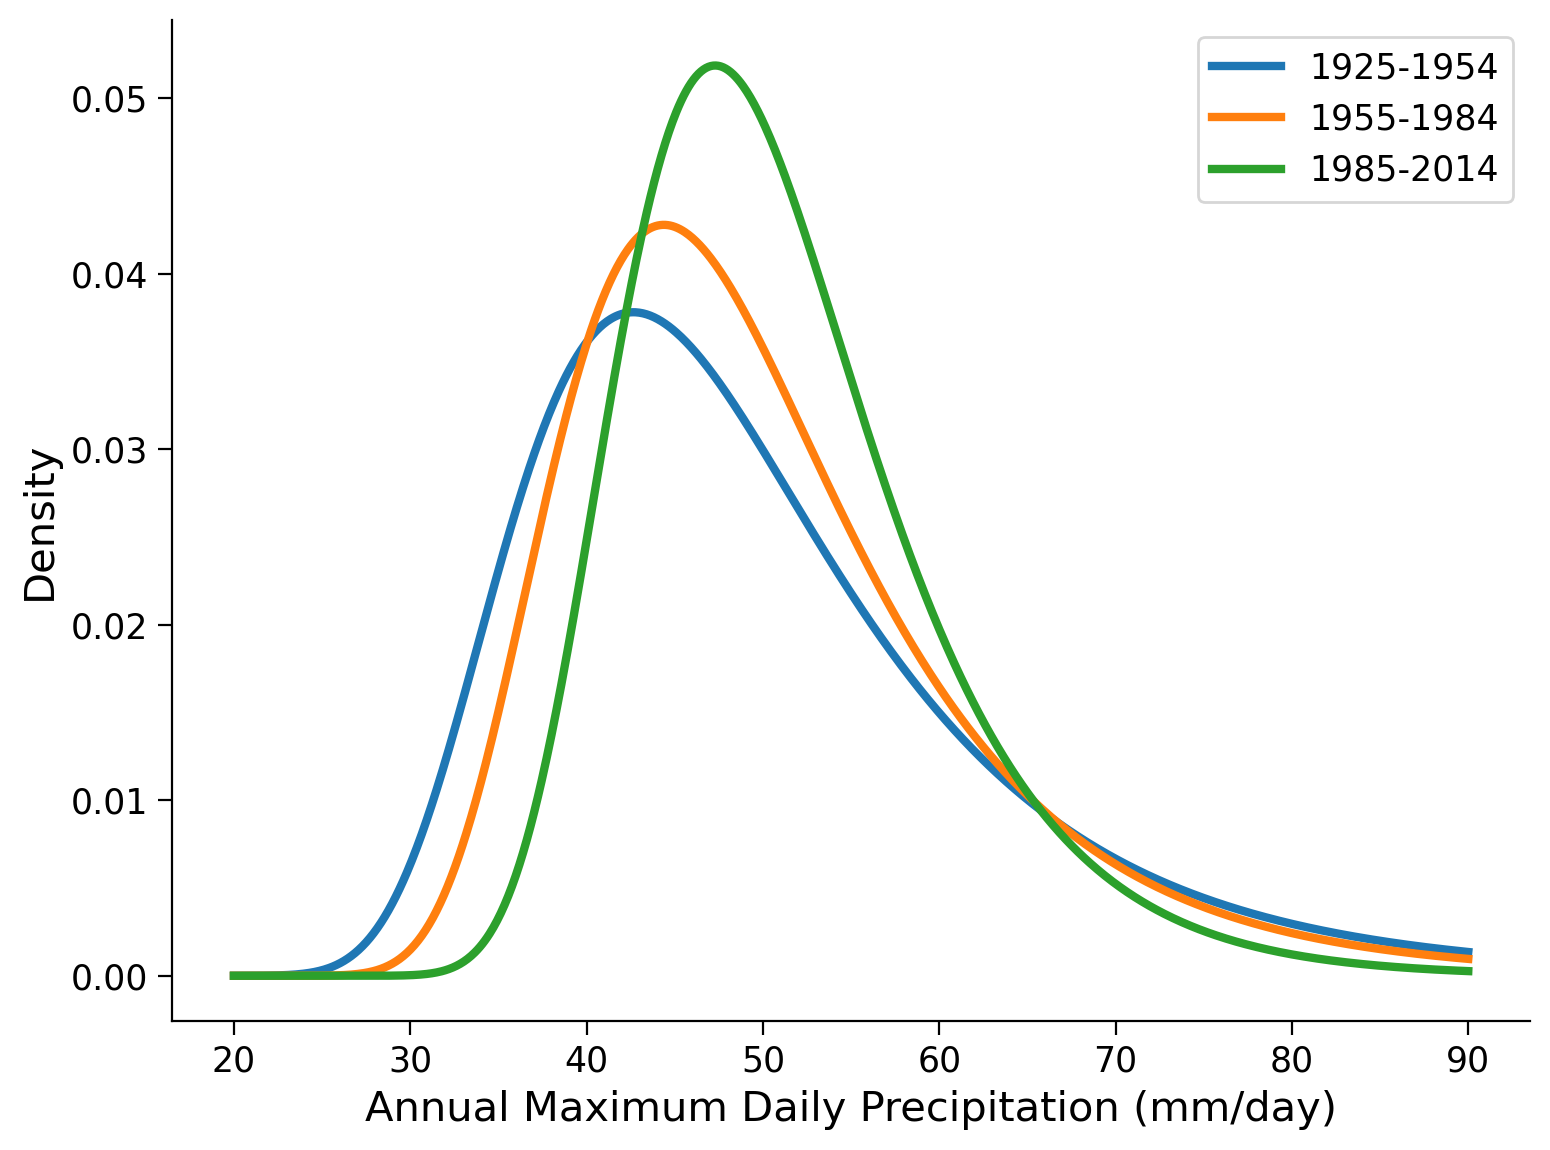

In [56]:
# plot corresponding PDFs of GEV distribution fits
fig, ax = plt.subplots()
x = np.linspace(20,90,1000)
ax.plot(x,gev.pdf(
    x,-shape_period1,
    loc=loc_period1,scale=scale_period1
    ),
    c='C0',lw=3,label='1925-1954')
ax.plot(x,gev.pdf(
    x,-shape_period2,
    loc=loc_period2,scale=scale_period2
    ),
    c='C1',lw=3,label='1955-1984')
ax.plot(x,gev.pdf(
    x,-shape_period3,
    loc=loc_period3,scale=scale_period3
    ),
    c='C2',lw=3,label='1985-2014')
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation (mm/day)')
ax.set_ylabel('Density')

In [37]:
# show the parameters of the GEV fit
parameters = pd.DataFrame(index=['Location', 'Scale', 'Shape'])
parameters['1925-1954'] = [loc_period1, scale_period1, shape_period1]
parameters['1955-1984'] = [loc_period2, scale_period2, shape_period2]
parameters['1985-2014'] = [loc_period3, scale_period3, shape_period3]

parameters = parameters.T
parameters.round(4)#.astype('%.2f')

,Location,Scale,Shape
1925-1954,43.5183,9.7693,0.0931
1955-1984,44.9420,8.6153,0.0673
1985-2014,47.1629,7.0925,-0.0177


Now we will create a return level plot for the three periods. To do so we will be using some helper functions defined at the beginning of the tutorial, most of which you have seen before.  In particular we will use `fit_return_levels` to generate an xr.Dataset that contains empirical and GEV fits, as well as confidence intervals, and `plot_return_levels` to generate a plot from this xr.Dataset with calculated confidence intervals shaded (alpha printed below).

These functions can also be found in gev_functions (`import gev_functions as gf`).

In [40]:
fit_period1 = fit_return_levels(data_period1,np.arange(1.1,1000,0.1),N_boot=100,alpha=0.05)
fit_period2 = fit_return_levels(data_period2,np.arange(1.1,1000,0.1),N_boot=100,alpha=0.05)
fit_period3 = fit_return_levels(data_period3,np.arange(1.1,1000,0.1),N_boot=100,alpha=0.05)

Location: 4.4e+01, scale: 9.8e+00, shape: 9.3e-02
Ranges with alpha=0.050 :
Location: [39.84 , 47.93]
Scale: [6.89 , 12.92]
Shape: [-0.26 , 0.59]
Location: 4.5e+01, scale: 8.6e+00, shape: 6.7e-02
Ranges with alpha=0.050 :
Location: [41.44 , 49.67]
Scale: [6.85 , 11.63]
Shape: [-0.25 , 0.37]
Location: 4.7e+01, scale: 7.1e+00, shape: -1.8e-02
Ranges with alpha=0.050 :
Location: [44.59 , 50.41]
Scale: [5.13 , 8.56]
Shape: [-0.25 , 0.17]


Text(0.5, 0, 'Return Period (years)')

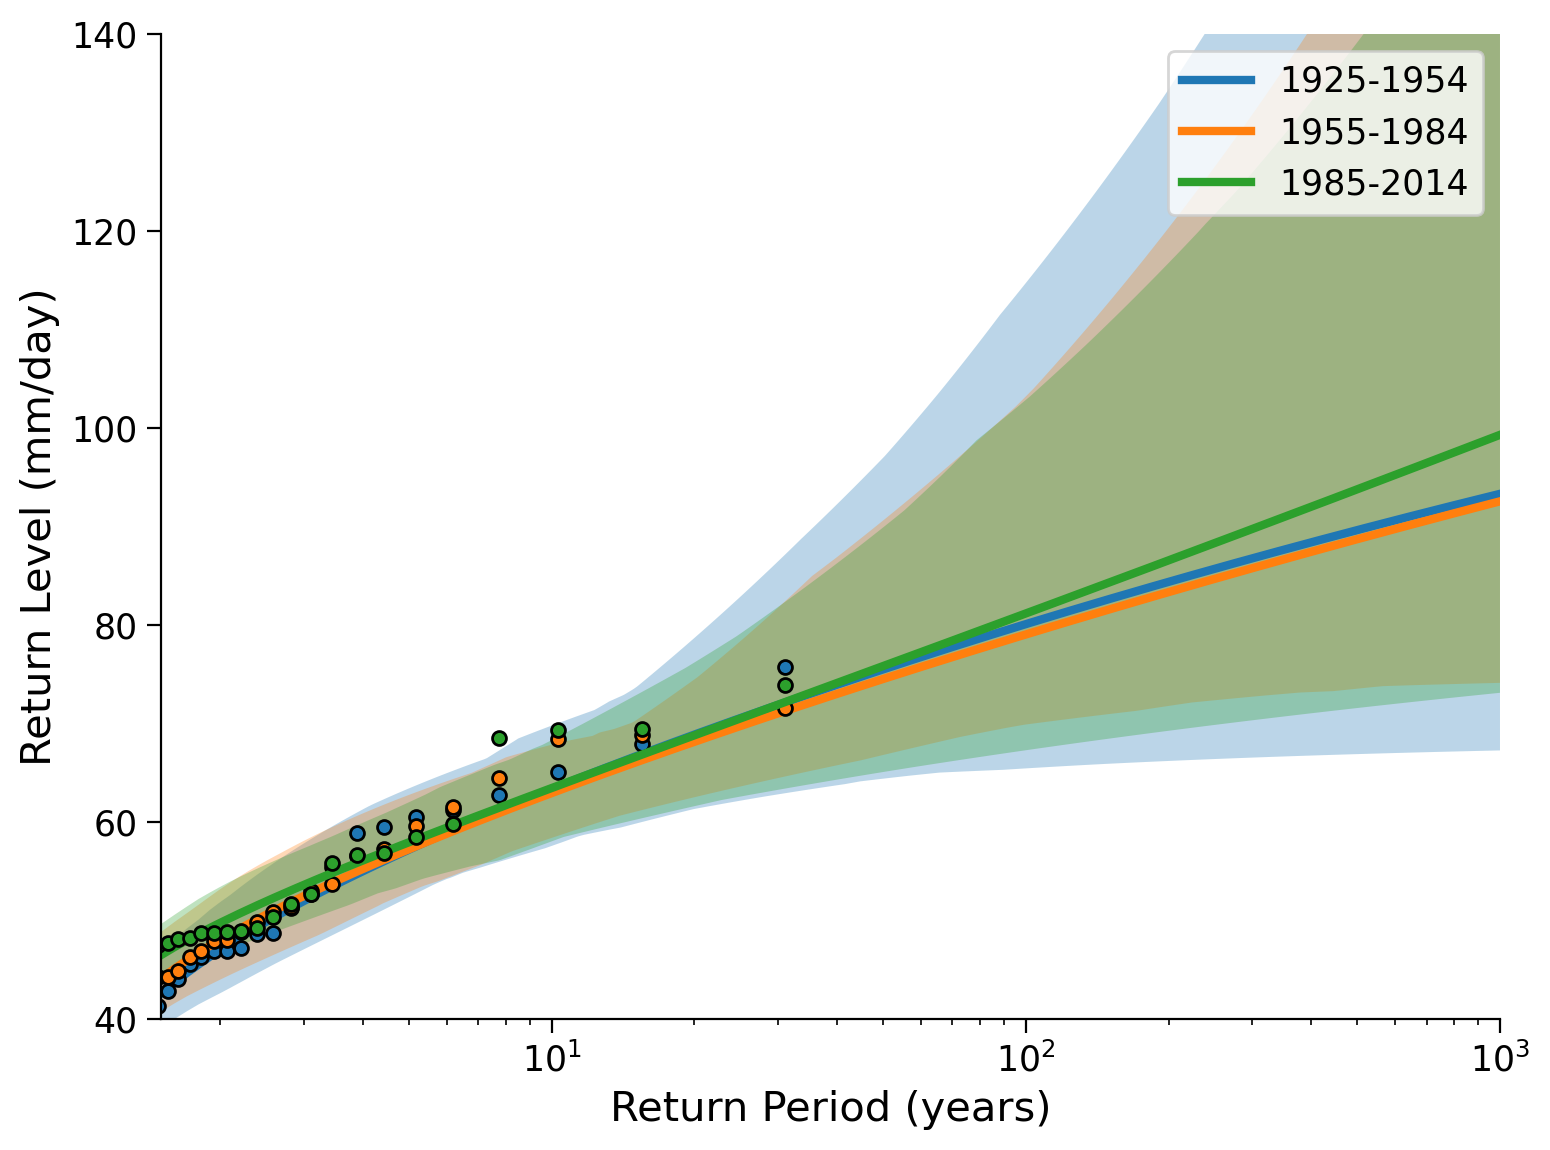

In [62]:
fig, ax= plt.subplots()
plot_return_levels(fit_period1,c='C0',label='1925-1954',ax=ax)
plot_return_levels(fit_period2,c='C1',label='1955-1984',ax=ax)
plot_return_levels(fit_period3,c='C2',label='1985-2014',ax=ax)
ax.set_xlim(1.5,1000)
ax.set_ylim(40,140)

ax.legend()
ax.set_ylabel('Return Level (mm/day)')
ax.set_xlabel('Return Period (years)')

## **Questions 3**

1. What do you conclude for the historical change in extreme precipitation in this city? What possible limitations could this analysis have? (How) could we address this?

In [66]:
# to_remove explanation
"""
1.  The changes over the historical period are relatively small, however there are larger return levels noted for the most recent climate normal from 1985-2014. One limitation is the length of time used, as the shape parameter is typically not well defined. Using a longer time interval and likely a better shape parameters could give us more confidence in our return level estimates.
""";

# **Section 4: Climate Futures**

Now let's look at maximum precipitation in possible climate futures: the years 2071-2100 (the last 30 years). For comparison we use the historical period, 1850-2014.

In the next box we select the data, then you will plot it as a coding exercise:

In [45]:
data_city = data.sel(city=city,model='MPI-ESM1-2-HR')
# data_city = data.sel(city=city,model='MIROC6')
data_city_fut  = data_city['pr'].sel(time=slice('2071','2100')).resample(time='1Y').max()

# select the different time periods
data_hist = data_city['pr'].sel(scenario='ssp126',time=slice('1850','2014')).resample(time='1Y').max().to_dataframe()['pr']
data_ssp126 = data_city_fut.sel(scenario='ssp126').to_dataframe()['pr']
data_ssp245 = data_city_fut.sel(scenario='ssp245').to_dataframe()['pr']
data_ssp585 = data_city_fut.sel(scenario='ssp585').to_dataframe()['pr']

## **Coding Exercises 4**
Differences between climate scenarios:

Repeat the analysis that we did above for three different time periods, but now for three different climate scenarios, and the historical period for comparison.
1. Create a figure that displays the histograms of the four records. Find a useful number and spacing of bins (via the bins= keyword to sns.histplot). Calculate the moments.
2. Fit GEV distributions to the four records using the same commands as above. Use the `gev.pdf` function to plot the fitted distributions.
3. Inspect location, scale and shape parameters
4. Create a return-level plot using the `ef.plot_levels_from_obj` function.

In [47]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise:  Plot the histograms and calculate the moments.")
#################################################

# setup plot
fig,ax = plt.subplots()

# create histograms for each scenario and historical
sns.histplot(...,bins=np.arange(30,100,5),color='k',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='Historical, 1850-2014',ax=ax)
sns.histplot(...,bins=np.arange(30,100,5),color='C0',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-126, 2071-2100',ax=ax)
sns.histplot(...,bins=np.arange(30,100,5),color='C0',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-126, 2071-2100',ax=ax)
sns.histplot(...,bins=np.arange(30,100,5),color='C1',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-245, 2071-2100',ax=ax)
sns.histplot(...,bins=np.arange(30,100,5),color='C2',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-585, 2071-2100',ax=ax)

# aesthetics
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation (mm/day)')

# calculate moments
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])
periods_stats[...] = [..., ..., ...]
periods_stats[...] = [..., ..., ...]
periods_stats[...] = [..., ..., ...]
periods_stats[...] = [..., ..., ...]
periods_stats = periods_stats.T
periods_stats

NotImplementedError: Student exercise:  Plot the histograms and calculate the moments.

,Mean,Standard Deviation,Skew
hist,49.269219,11.119333,0.693951
ssp126,51.130332,9.557283,0.476350
ssp245,55.264835,14.017823,0.764946
ssp585,60.534207,11.782039,0.276712


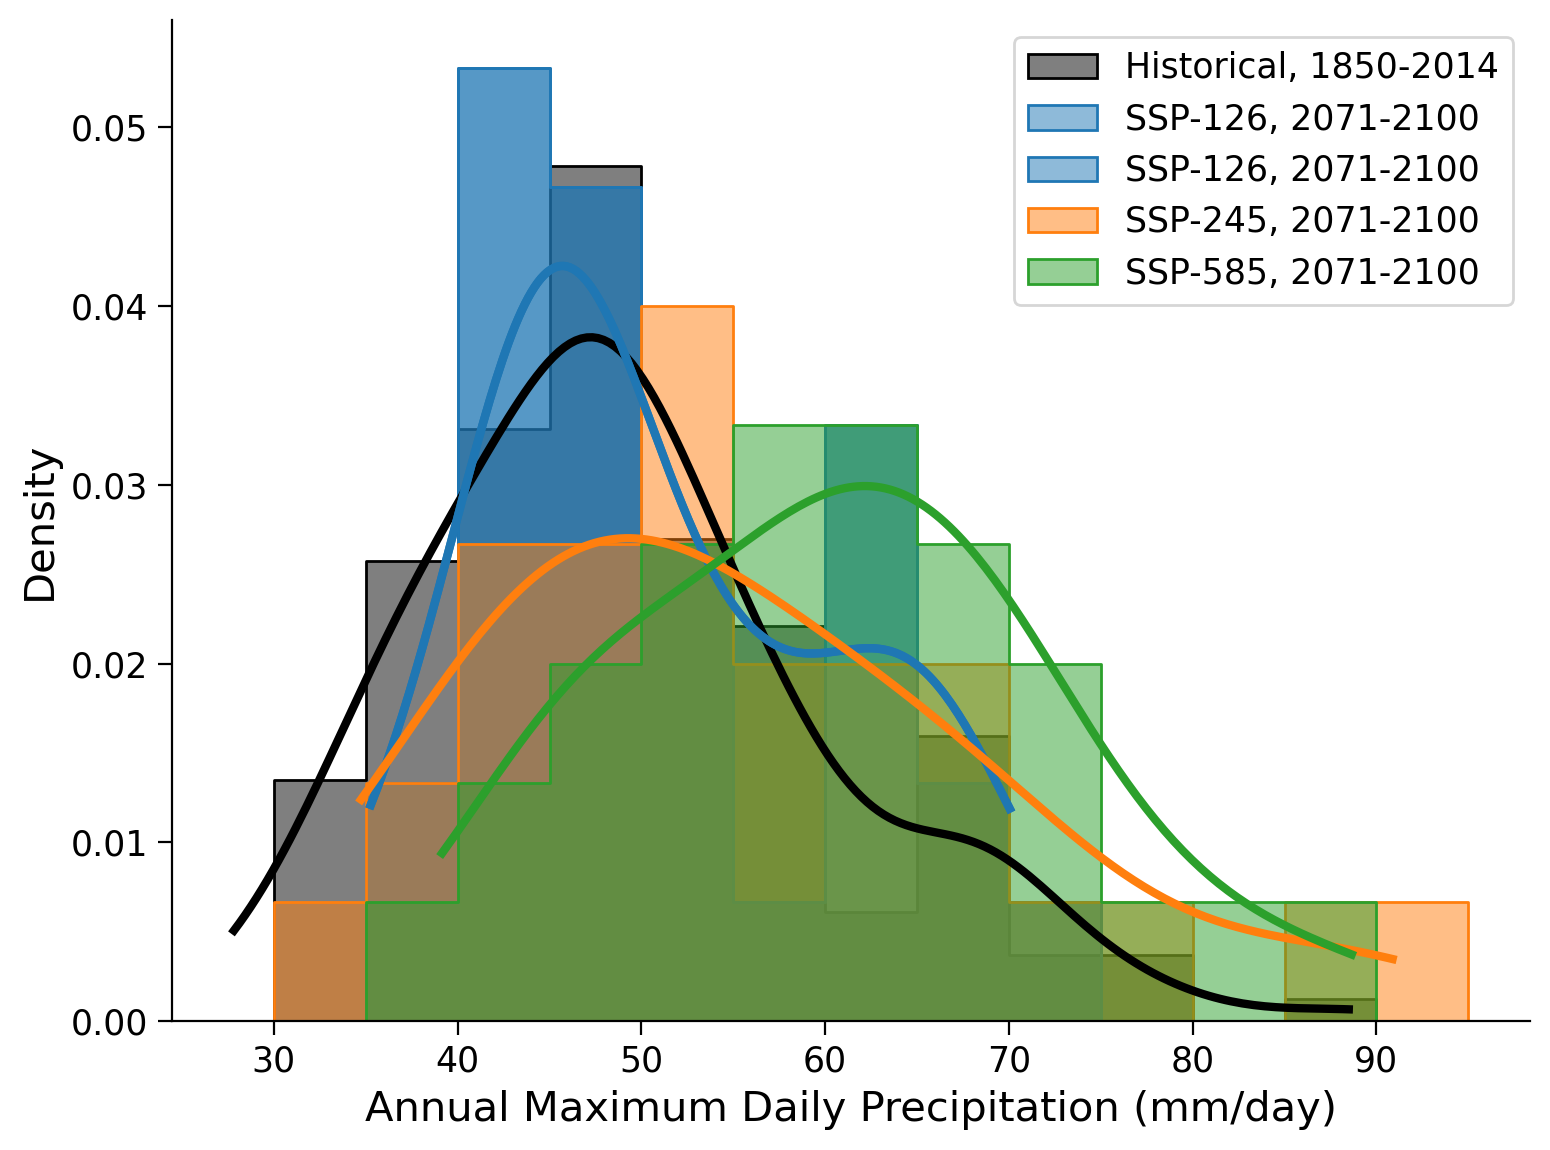

In [48]:
# to_remove solution

# setup plot
fig,ax = plt.subplots()

# create histograms for each scenario and historical
sns.histplot(data_hist,bins=np.arange(30,100,5),color='k',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='Historical, 1850-2014',ax=ax)
sns.histplot(data_ssp126,bins=np.arange(30,100,5),color='C0',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-126, 2071-2100',ax=ax)
sns.histplot(data_ssp126,bins=np.arange(30,100,5),color='C0',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-126, 2071-2100',ax=ax)
sns.histplot(data_ssp245,bins=np.arange(30,100,5),color='C1',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-245, 2071-2100',ax=ax)
sns.histplot(data_ssp585,bins=np.arange(30,100,5),color='C2',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-585, 2071-2100',ax=ax)

# aesthetics
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation (mm/day)')

# calculate moments
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])
periods_stats['hist'] = [data_hist.mean(), data_hist.std(), data_hist.skew()]
periods_stats['ssp126'] = [data_ssp126.mean(), data_ssp126.std(), data_ssp126.skew()]
periods_stats['ssp245'] = [data_ssp245.mean(), data_ssp245.std(), data_ssp245.skew()]
periods_stats['ssp585'] = [data_ssp585.mean(), data_ssp585.std(), data_ssp585.skew()]
periods_stats = periods_stats.T
periods_stats

In [57]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise:  Fit GEV distribution and plot PDFs.")
#################################################

# fit GEV distribution
shape_hist, loc_hist, scale_hist = ...
shape_ssp126, loc_ssp126, scale_ssp126 = ...
shape_ssp245, loc_ssp245, scale_ssp245 = ...
shape_ssp585, loc_ssp585, scale_ssp585 = ...

# make plots
fig, ax = plt.subplots()
x = np.linspace(20,120,1000)
ax.plot(x,gev.pdf(
    x, 
    ..., 
    loc=..., 
    scale=...
    ),
    c='k',lw=3,label='historical, 1850-2014')
ax.plot(x,gev.pdf(
    x, 
    ..., 
    loc=..., 
    scale=...
    ),
    c='C0',lw=3,label='SSP-126, 2071-2100')
ax.plot(x,gev.pdf(
    x, 
    ..., 
    loc=..., 
    scale=...
    ),
    c='C1',lw=3,label='SSP-245, 2071-2100')
ax.plot(x,gev.pdf(
    x, 
    ..., 
    loc=..., 
    scale=...
    ),
    c='C2',lw=3,label='SSP-585, 2071-2100')
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation (mm/day)')
ax.set_ylabel('Density');

NotImplementedError: Student exercise:  Fit GEV distribution and plot PDFs.

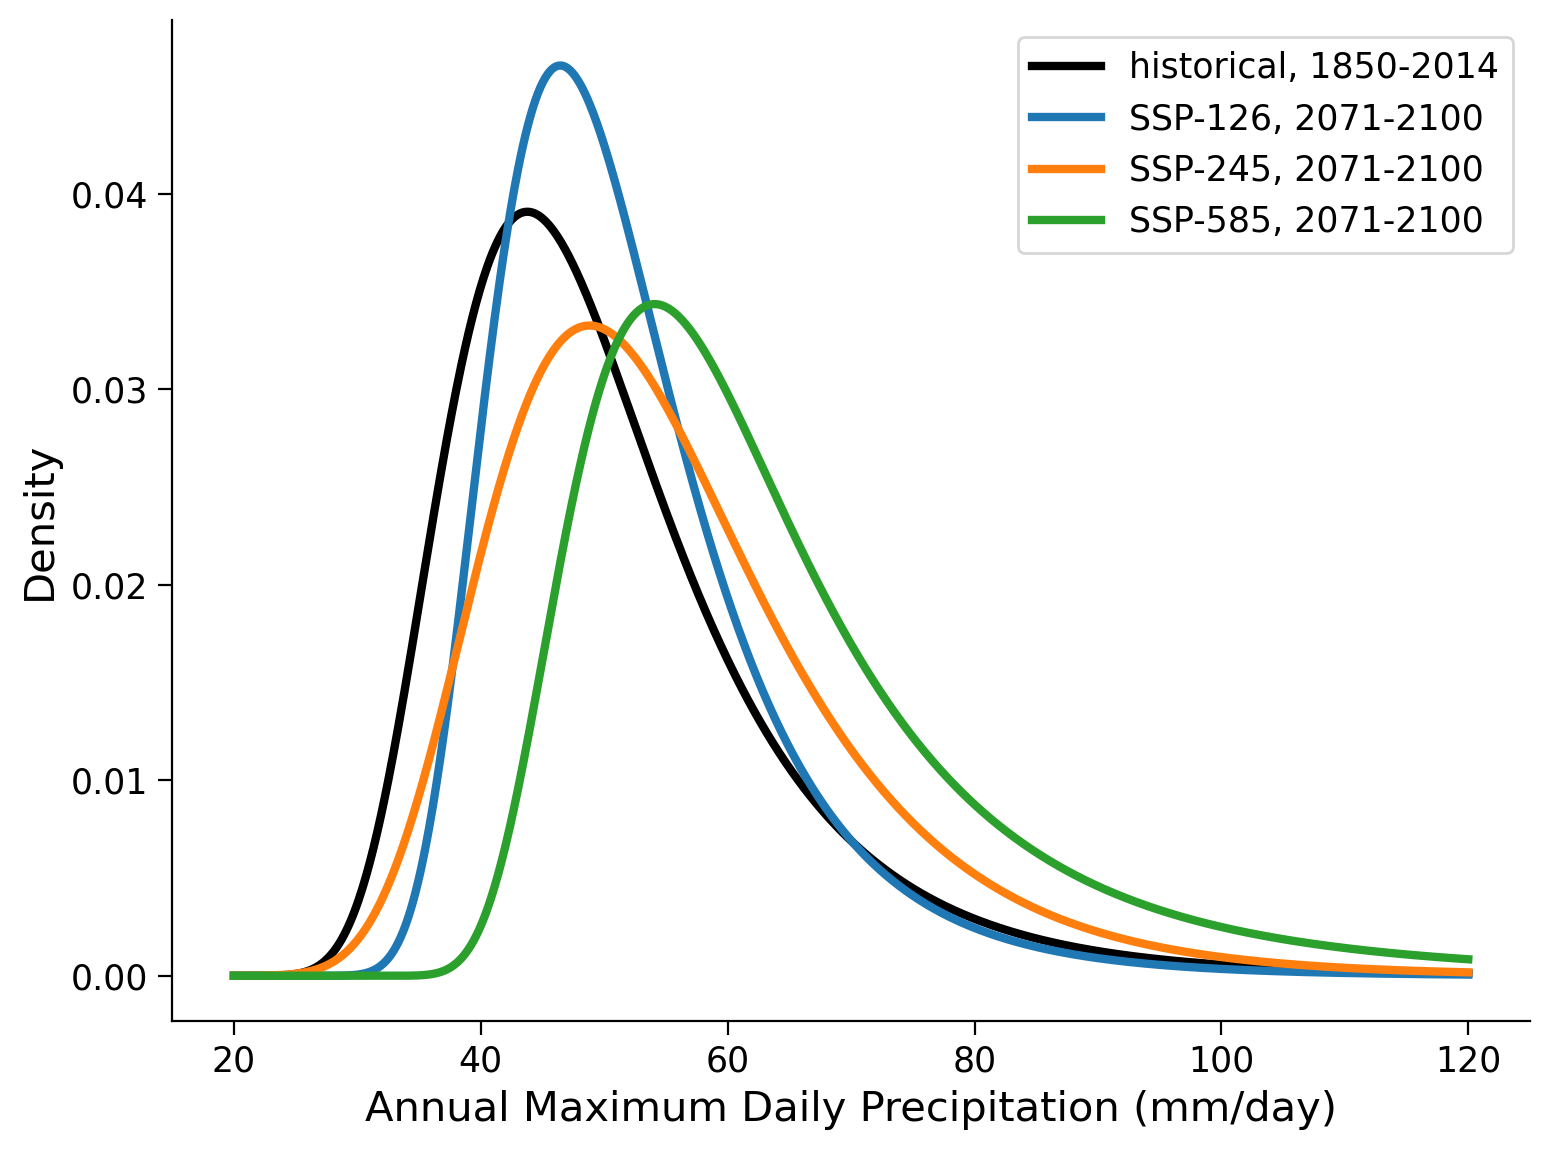

In [58]:
# to_remove solution

# fit GEV distribution
shape_hist, loc_hist, scale_hist = gev.fit(data_hist)
shape_ssp126, loc_ssp126, scale_ssp126 = gev.fit(data_ssp126)
shape_ssp245, loc_ssp245, scale_ssp245 = gev.fit(data_ssp245)
shape_ssp585, loc_ssp585, scale_ssp585 = gev.fit(data_ssp585)

# make plots
fig, ax = plt.subplots()
x = np.linspace(20,120,1000)
ax.plot(x,gev.pdf(
    x, 
    -shape_hist, 
    loc=loc_hist, 
    scale=scale_hist
    ),
    c='k',lw=3,label='historical, 1850-2014')
ax.plot(x,gev.pdf(
    x, 
    -shape_ssp126, 
    loc=loc_ssp126, 
    scale=scale_ssp126
    ),
    c='C0',lw=3,label='SSP-126, 2071-2100')
ax.plot(x,gev.pdf(
    x, 
    -shape_ssp245, 
    loc=loc_ssp245, 
    scale=scale_ssp245
    ),
    c='C1',lw=3,label='SSP-245, 2071-2100')
ax.plot(x,gev.pdf(
    x, 
    -shape_ssp585, 
    loc=loc_ssp585, 
    scale=scale_ssp585
    ),
    c='C2',lw=3,label='SSP-585, 2071-2100')
ax.legend()
ax.set_xlabel('Annual Maximum Daily Precipitation (mm/day)')
ax.set_ylabel('Density');

In [61]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise:  Find and plot return levels.")
#################################################

# find return levels
fit_hist = fit_return_levels(...,np.arange(1.1,200,0.1),N_boot=100,alpha=0.05)
fit_ssp126 = ...
fit_ssp245 = ...
fit_ssp585 = ...


# plot
fig,ax=plt.subplots()
plot_return_levels(...,c='k',label='historical, 1850-2014',ax=ax)
plot_return_levels(...,c='C0',label='SSP-126, 2071-2100',ax=ax)
plot_return_levels(...,c='C1',label='SSP-245, 2071-2100',ax=ax)
plot_return_levels(...,c='C2',label='SSP-585, 2071-2100',ax=ax)
ax.set_xlim(1,200)
ax.set_ylim(30,110)
ax.set_ylabel('Return Level (mm/day)')
ax.set_xlabel('Return Period (years)')

NotImplementedError: Student exercise:  Find and plot return levels.

Location: 4.4e+01, scale: 9.4e+00, shape: 7.8e-02
Ranges with alpha=0.050 :
Location: [43.04 , 46.09]
Scale: [8.20 , 10.53]
Shape: [-0.00 , 0.16]
Location: 4.7e+01, scale: 7.9e+00, shape: 6.9e-02
Ranges with alpha=0.050 :
Location: [43.87 , 53.12]
Scale: [4.48 , 12.33]
Shape: [-0.57 , 0.85]
Location: 4.9e+01, scale: 1.1e+01, shape: 1.3e-02
Ranges with alpha=0.050 :
Location: [45.42 , 55.15]
Scale: [8.83 , 14.18]
Shape: [-0.22 , 0.25]
Location: 5.6e+01, scale: 1.1e+01, shape: 2.0e-01
Ranges with alpha=0.050 :
Location: [51.40 , 61.20]
Scale: [8.53 , 13.00]
Shape: [-0.07 , 0.46]


Text(0.5, 0, 'Return Period (years)')

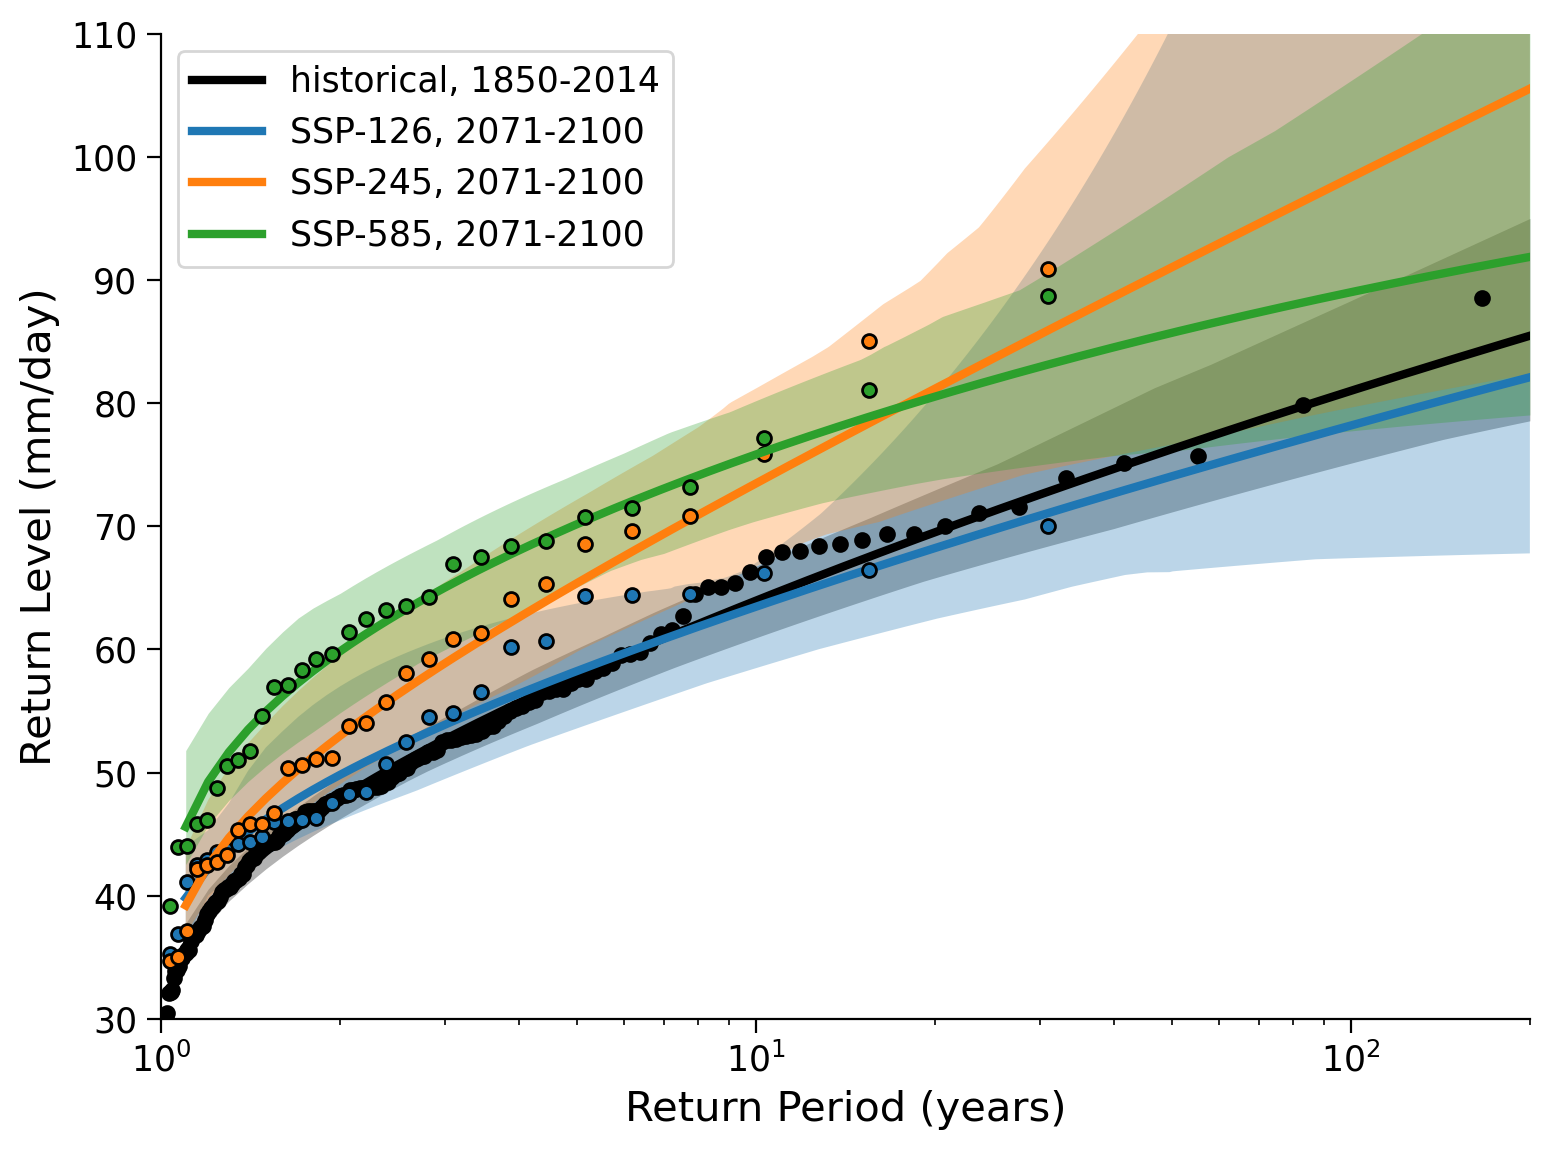

In [63]:
# to_remove solution

# find return levels
fit_hist = fit_return_levels(data_hist,np.arange(1.1,200,0.1),N_boot=100,alpha=0.05)
fit_ssp126 = fit_return_levels(data_ssp126,np.arange(1.1,200,0.1),N_boot=100,alpha=0.05)
fit_ssp245 = fit_return_levels(data_ssp245,np.arange(1.1,200,0.1),N_boot=100,alpha=0.05)
fit_ssp585 = fit_return_levels(data_ssp585,np.arange(1.1,200,0.1),N_boot=100,alpha=0.05)


# plot
fig,ax=plt.subplots()
plot_return_levels(fit_hist,c='k',label='historical, 1850-2014',ax=ax)
plot_return_levels(fit_ssp126,c='C0',label='SSP-126, 2071-2100',ax=ax)
plot_return_levels(fit_ssp245,c='C1',label='SSP-245, 2071-2100',ax=ax)
plot_return_levels(fit_ssp585,c='C2',label='SSP-585, 2071-2100',ax=ax)
ax.set_xlim(1,200)
ax.set_ylim(30,110)
ax.set_ylabel('Return Level (mm/day)')
ax.set_xlabel('Return Period (years)')

## **Questions 4**

1. What can you say about how extreme precipitation differs between the climate scenarios? Are the differences large or small compared to periods in the historical records? What are the limitations? Consider the x-axis in the return-level plot compared to the space covered by the data (only 30 years). How could we get more information for longer return periods?

In [65]:
# to_remove explanation
"""
The differences between the scenarios and the historical records are large for SSP 245 and SSP 558, while such difference is small for SSP 126. In general, we might expect larger differences as we move towards more extreme emission scenarios and further into the future. One limitation is the inherent uncertainty in any climate model. These models make assumptions about future emissions and other factors, which might not pan out exactly as predicted. Another limitation is the relatively short period covered by the data (only 30 years). To gain more information about longer return periods, you could use longer time series of data if available, for example from paleo-simulations, proxies, or reanalysis products. 
""";

# **Summary**
In this tutorial, you've learned how to analyze climate model output to investigate the changes in extreme precipitation patterns over time under various emission scenarios and the historical period. Specifically, we've focused on three future Shared Socioeconomic Pathways (SSPs) scenarios, which represent potential futures based on different assumptions about greenhouse gas emissions.

You've explored how to fit Generalized Extreme Value (GEV) distributions to the data and used these fitted distributions to create return-level plots. These plots allow us to visualize the probability of extreme events under different climate scenarios.

# **Resources**

Data for this tutorial can be accessed [here](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html). Additionally, an extra notebook is available here that downloads the specific datasets we used in this tutorial. NEED TO ADD LINK once pushed to main.